# Day 5: Volatility Forecasting Comparison

## Learning Objectives
- Compare different volatility forecasting methods
- Implement HAR-RV model
- Evaluate forecast accuracy
- Understand realized volatility measures

## Methods Covered
- Rolling window (historical)
- EWMA
- GARCH family
- HAR-RV (Heterogeneous Autoregressive Realized Volatility)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252

df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna()

# Use SPY for analysis
stock = 'SPY'
ret = returns[stock].dropna()

print("="*60)
print("VOLATILITY FORECASTING COMPARISON - DAY 5")
print("="*60)
print(f"Stock: {stock}")
print(f"Data: {len(ret)} observations")

VOLATILITY FORECASTING COMPARISON - DAY 5
Stock: SPY
Data: 1834 observations


## 1. Realized Volatility as Target

In [2]:
# Calculate realized volatility measures
def calc_realized_vol(returns, window=20):
    """Calculate forward-looking realized volatility."""
    return returns.rolling(window).std().shift(-window) * np.sqrt(TRADING_DAYS)

# Different horizons
rv_5d = calc_realized_vol(ret, 5) * 100
rv_20d = calc_realized_vol(ret, 20) * 100
rv_60d = calc_realized_vol(ret, 60) * 100

print("\n" + "="*60)
print("REALIZED VOLATILITY STATISTICS")
print("="*60)
print(f"{'Horizon':<15} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
print("-"*50)
for name, rv in [('5-day', rv_5d), ('20-day', rv_20d), ('60-day', rv_60d)]:
    print(f"{name:<15} {rv.mean():<10.2f} {rv.std():<10.2f} {rv.min():<10.2f} {rv.max():<10.2f}")


REALIZED VOLATILITY STATISTICS
Horizon         Mean       Std        Min        Max       
--------------------------------------------------
5-day           15.04      12.84      1.06       140.23    
20-day          16.08      11.07      4.77       93.19     
60-day          16.99      9.84       6.56       61.03     


## 2. Forecasting Methods

In [3]:
# 1. Rolling Window (Historical Volatility)
def forecast_rolling(returns, window=20):
    return returns.rolling(window).std() * np.sqrt(TRADING_DAYS)

# 2. EWMA
def forecast_ewma(returns, lambda_param=0.94):
    return returns.ewm(alpha=(1-lambda_param), min_periods=20).std() * np.sqrt(TRADING_DAYS)

# 3. GARCH(1,1)
def forecast_garch(returns):
    model = arch_model(returns * 100, vol='GARCH', p=1, q=1)
    result = model.fit(disp='off')
    return result.conditional_volatility * np.sqrt(TRADING_DAYS) / 100

# 4. EGARCH
def forecast_egarch(returns):
    model = arch_model(returns * 100, vol='EGARCH', p=1, o=1, q=1)
    result = model.fit(disp='off')
    return result.conditional_volatility * np.sqrt(TRADING_DAYS) / 100

# Generate forecasts
forecasts = {
    'Rolling 20': forecast_rolling(ret, 20),
    'Rolling 60': forecast_rolling(ret, 60),
    'EWMA 0.94': forecast_ewma(ret, 0.94),
    'EWMA 0.97': forecast_ewma(ret, 0.97),
    'GARCH': forecast_garch(ret),
    'EGARCH': forecast_egarch(ret)
}

# Convert to percentage
forecasts = {k: v * 100 for k, v in forecasts.items()}

print("\nForecasts generated for all methods")


Forecasts generated for all methods


In [4]:
# HAR-RV Model (Heterogeneous Autoregressive)
# Uses daily, weekly, and monthly RV components

# Calculate RV components
daily_rv = np.abs(ret) * np.sqrt(TRADING_DAYS) * 100
weekly_rv = ret.rolling(5).std() * np.sqrt(TRADING_DAYS) * 100
monthly_rv = ret.rolling(20).std() * np.sqrt(TRADING_DAYS) * 100

# Create HAR-RV dataset
har_data = pd.DataFrame({
    'RV_target': rv_20d,  # Target: 20-day forward RV
    'RV_daily': daily_rv,
    'RV_weekly': weekly_rv,
    'RV_monthly': monthly_rv
}).dropna()

# Simple OLS for HAR-RV
from sklearn.linear_model import LinearRegression

# Train on first 80%, test on last 20%
train_size = int(len(har_data) * 0.8)
train_data = har_data.iloc[:train_size]
test_data = har_data.iloc[train_size:]

X_train = train_data[['RV_daily', 'RV_weekly', 'RV_monthly']]
y_train = train_data['RV_target']
X_test = test_data[['RV_daily', 'RV_weekly', 'RV_monthly']]
y_test = test_data['RV_target']

har_model = LinearRegression()
har_model.fit(X_train, y_train)

print("\n" + "="*60)
print("HAR-RV MODEL COEFFICIENTS")
print("="*60)
print(f"Intercept: {har_model.intercept_:.4f}")
print(f"Daily RV coefficient: {har_model.coef_[0]:.4f}")
print(f"Weekly RV coefficient: {har_model.coef_[1]:.4f}")
print(f"Monthly RV coefficient: {har_model.coef_[2]:.4f}")


HAR-RV MODEL COEFFICIENTS
Intercept: 7.8996
Daily RV coefficient: 0.1073
Weekly RV coefficient: 0.3068
Monthly RV coefficient: 0.1498


## 3. Forecast Evaluation

In [5]:
# Evaluate forecasts against 20-day realized volatility
# Use test period
test_idx = har_data.index[train_size:]
target = rv_20d.loc[test_idx].dropna()

def evaluate_forecast(forecast, target, name):
    """Evaluate forecast accuracy."""
    # Align indices
    common_idx = forecast.dropna().index.intersection(target.index)
    f = forecast.loc[common_idx]
    t = target.loc[common_idx]
    
    rmse = np.sqrt(mean_squared_error(t, f))
    mae = mean_absolute_error(t, f)
    corr = np.corrcoef(t, f)[0, 1]
    bias = (f - t).mean()
    
    return {'Model': name, 'RMSE': rmse, 'MAE': mae, 'Corr': corr, 'Bias': bias}

# Evaluate all methods
results = []
for name, forecast in forecasts.items():
    result = evaluate_forecast(forecast, target, name)
    results.append(result)

# Add HAR-RV
har_forecast = pd.Series(har_model.predict(X_test), index=test_data.index)
results.append(evaluate_forecast(har_forecast, y_test, 'HAR-RV'))

# Display results
results_df = pd.DataFrame(results)

print("\n" + "="*70)
print("FORECAST ACCURACY COMPARISON (20-day horizon)")
print("="*70)
print(results_df.to_string(index=False))

# Best model
print(f"\n✓ Best by RMSE: {results_df.loc[results_df['RMSE'].idxmin(), 'Model']}")
print(f"✓ Best by Correlation: {results_df.loc[results_df['Corr'].idxmax(), 'Model']}")


FORECAST ACCURACY COMPARISON (20-day horizon)
     Model      RMSE      MAE     Corr     Bias
Rolling 20 11.810674 7.309636 0.288142 0.645312
Rolling 60 12.617080 8.039091 0.028822 1.388529
 EWMA 0.94 11.539647 7.536525 0.231136 1.260782
 EWMA 0.97 11.674517 7.849607 0.091021 1.914644
     GARCH 10.997937 6.630978 0.324626 0.974136
    EGARCH  9.057663 5.785886 0.469941 0.495553
    HAR-RV  9.592725 5.939182 0.351930 0.912328

✓ Best by RMSE: EGARCH
✓ Best by Correlation: EGARCH


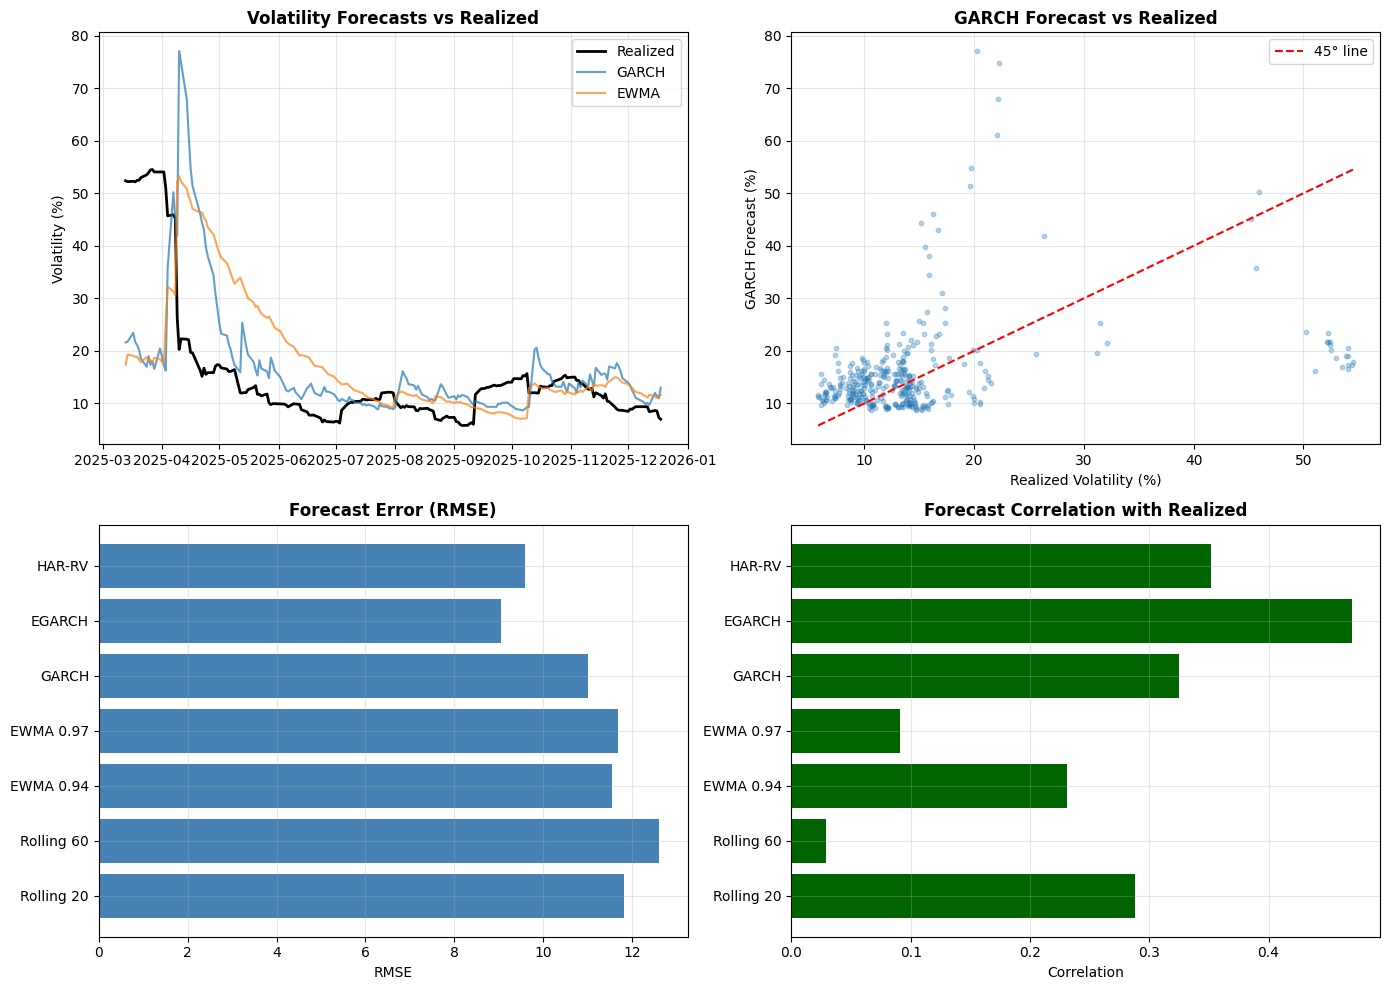

In [6]:
# Visualize forecasts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series comparison
ax1 = axes[0, 0]
ax1.plot(target.iloc[-200:], label='Realized', color='black', linewidth=2)
ax1.plot(forecasts['GARCH'].loc[target.index].iloc[-200:], label='GARCH', alpha=0.7)
ax1.plot(forecasts['EWMA 0.94'].loc[target.index].iloc[-200:], label='EWMA', alpha=0.7)
ax1.set_title('Volatility Forecasts vs Realized', fontweight='bold')
ax1.set_ylabel('Volatility (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter: GARCH vs Realized
ax2 = axes[0, 1]
garch_aligned = forecasts['GARCH'].loc[target.index].dropna()
target_aligned = target.loc[garch_aligned.index]
ax2.scatter(target_aligned, garch_aligned, alpha=0.3, s=10)
ax2.plot([target_aligned.min(), target_aligned.max()], 
         [target_aligned.min(), target_aligned.max()], 'r--', label='45° line')
ax2.set_xlabel('Realized Volatility (%)')
ax2.set_ylabel('GARCH Forecast (%)')
ax2.set_title('GARCH Forecast vs Realized', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Error bar chart
ax3 = axes[1, 0]
ax3.barh(results_df['Model'], results_df['RMSE'], color='steelblue')
ax3.set_xlabel('RMSE')
ax3.set_title('Forecast Error (RMSE)', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Correlation bar chart
ax4 = axes[1, 1]
ax4.barh(results_df['Model'], results_df['Corr'], color='darkgreen')
ax4.set_xlabel('Correlation')
ax4.set_title('Forecast Correlation with Realized', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Mincer-Zarnowitz Regression

In [7]:
# Mincer-Zarnowitz regression for forecast efficiency
# RV_t = α + β * Forecast_t + ε_t
# Efficient forecast: α = 0, β = 1

from sklearn.linear_model import LinearRegression

print("\n" + "="*70)
print("MINCER-ZARNOWITZ REGRESSION")
print("Efficient forecast: α = 0, β = 1")
print("="*70)
print(f"{'Model':<12} {'α (intercept)':<15} {'β (slope)':<12} {'R²':<10}")
print("-"*50)

for name in ['GARCH', 'EWMA 0.94', 'Rolling 20']:
    forecast = forecasts[name].loc[target.index].dropna()
    target_aligned = target.loc[forecast.index]
    
    X = forecast.values.reshape(-1, 1)
    y = target_aligned.values
    
    reg = LinearRegression().fit(X, y)
    r2 = reg.score(X, y)
    
    print(f"{name:<12} {reg.intercept_:<15.4f} {reg.coef_[0]:<12.4f} {r2:<10.4f}")

print("\n💡 β < 1: Forecast overshoots; β > 1: Forecast undershoots")


MINCER-ZARNOWITZ REGRESSION
Efficient forecast: α = 0, β = 1
Model        α (intercept)   β (slope)    R²        
--------------------------------------------------
GARCH        9.0610          0.3606       0.1054    
EWMA 0.94    10.4335         0.2682       0.0534    
Rolling 20   10.2836         0.2887       0.0830    

💡 β < 1: Forecast overshoots; β > 1: Forecast undershoots


## 5. Different Forecast Horizons

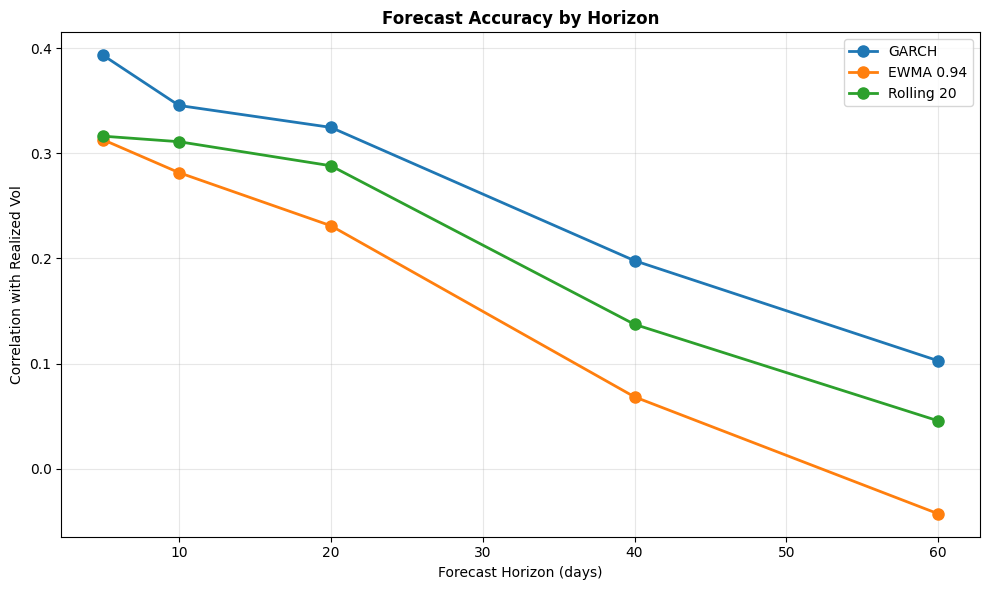


💡 Forecasts typically degrade at longer horizons


In [8]:
# Evaluate at different horizons
horizons = [5, 10, 20, 40, 60]

horizon_results = []
for h in horizons:
    rv_h = calc_realized_vol(ret, h) * 100
    target_h = rv_h.loc[test_idx].dropna()
    
    for method in ['GARCH', 'EWMA 0.94', 'Rolling 20']:
        forecast = forecasts[method]
        common_idx = forecast.dropna().index.intersection(target_h.index)
        f = forecast.loc[common_idx]
        t = target_h.loc[common_idx]
        
        corr = np.corrcoef(t, f)[0, 1]
        horizon_results.append({
            'Horizon': h,
            'Method': method,
            'Correlation': corr
        })

horizon_df = pd.DataFrame(horizon_results)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

for method in ['GARCH', 'EWMA 0.94', 'Rolling 20']:
    data = horizon_df[horizon_df['Method'] == method]
    ax.plot(data['Horizon'], data['Correlation'], 'o-', linewidth=2, markersize=8, label=method)

ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('Correlation with Realized Vol')
ax.set_title('Forecast Accuracy by Horizon', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Forecasts typically degrade at longer horizons")

## Key Takeaways

1. **GARCH often beats simple methods** for short horizons
2. **EWMA is a good practical choice** - simple and competitive
3. **HAR-RV captures multiple time scales** - good for longer horizons
4. **Mincer-Zarnowitz regression** tests forecast efficiency
5. **All forecasts degrade** at longer horizons

### Key Metrics
- **RMSE**: Penalizes large errors more
- **MAE**: Robust to outliers
- **Correlation**: Measures directional accuracy
- **Mincer-Zarnowitz**: Tests for systematic bias

---
*Next: Day 6 - Volatility Trading Strategies*